In [1]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


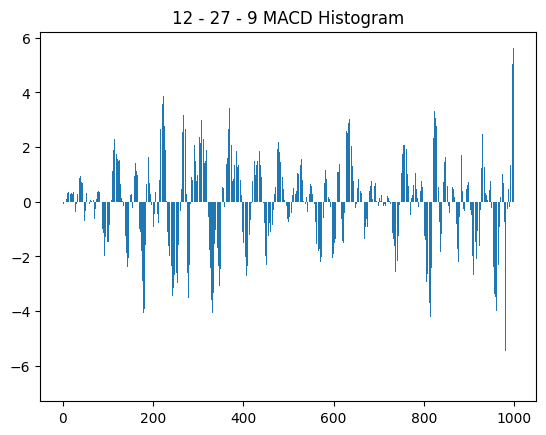

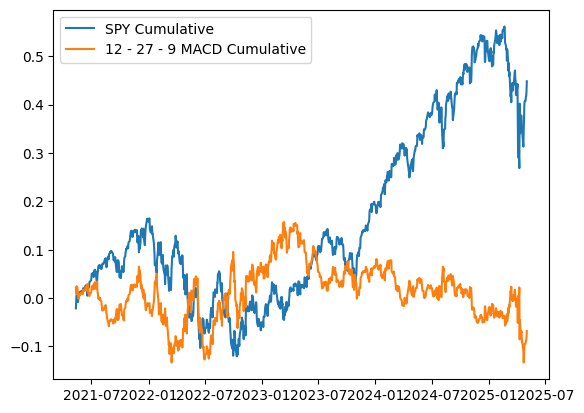

In [2]:
TICKER = 'SPY'
MACD_FAST = 12
MACD_SLOW = 27
MACD_SPAN = 9
LOOKBACK = 1000

def get_data(ticker=TICKER):
    df = yf.download(ticker)
    df.columns = df.columns.get_level_values(0)

    # only return the subset of data you are interested in
    return df.iloc[-LOOKBACK:, :]

def add_MACD(df, fast=MACD_FAST, slow=MACD_SLOW, span=MACD_SPAN):

    df[f'{fast}_ema'] = df['Close'].ewm(span=fast).mean()
    df[f'{slow}_ema'] = df['Close'].ewm(span=slow).mean()

    # macd line is the difference betweent he fast and slow
    df[f'MACD'] = df[f'{fast}_ema'] - df[f'{slow}_ema']

    # macd signal is a 9-period moving average of this line
    df['Signal'] = df['MACD'].ewm(span=span).mean()

    # MACD histogram is almost always what is used in TA
    df['MACD_hist'] = df['MACD'] - df['Signal']

    # plot the histogram
    plt.bar(x=range(len(df)), height=df['MACD_hist'])
    plt.title(f'{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Histogram')

    return df

def add_strategy(df):

    df['Strategy'] = 0
    df['Strategy'] = np.where(df['MACD_hist'] > 0, 1, -1)
    df['Strategy'] = df['Strategy'].shift(1)
    return df

def test_strategy(df):

    df['Asset_Returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1 + df['Close'].pct_change() * df['Strategy']).cumprod() -1

    plt.figure()
    plt.plot(df['Asset_Returns'])
    plt.plot(df['Strategy_Returns'])
    plt.legend([f'{TICKER} Cumulative', f'{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Cumulative'])

    return df

def main():
    df = get_data()
    df = add_MACD(df)
    df = add_strategy(df)
    df = test_strategy(df)

    return df

df = main()